In [1]:
# https://colab.research.google.com/drive/1V75UgfJEfCWgbfxnG4OuB1WpvqahUJPU?pli=1#scrollTo=2r5-59a3_oMF

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import multivariate_normal as mvn

from tqdm import tqdm

import matplotlib.pyplot as plt
import lib.draw as draw
import imageio

In [3]:
def influence_function(player_index, location, time_index, home_or_away):
  if home_or_away == 'h':
    data = locs_home.copy()
  elif home_or_away == 'a':
    data = locs_away.copy()
  else:
    raise ValueError("Enter either 'h' or 'a'.")
  # Added condition to process last frame
  if (time_index + 1) >= len(data[player_index]):
    time_index -= 1
  if np.all(np.isfinite(data[player_index][[time_index,time_index + 1],:])) & np.all(np.isfinite(locs_ball[0][time_index,:])):
    jitter = 1e-10 ## to prevent identically zero covariance matrices when velocity is zero
    ## compute velocity by fwd difference
    s = np.linalg.norm(data[player_index][time_index + 1,:] - data[player_index][time_index,:] + jitter) / (t[time_index + 1] - t[time_index])
    ## velocities in x,y directions
    sxy = (data[player_index][time_index + 1,:] - data[player_index][time_index,:] + jitter) / (t[time_index + 1] - t[time_index])
    ## angle between velocity vector & x-axis
    theta = np.arccos(sxy[0] / np.linalg.norm(sxy))
    ## rotation matrix
    R = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta),np.cos(theta)]])
    mu = data[player_index][time_index,:] + sxy * 0.5
    Srat = (s / 13) ** 2
    Ri = np.linalg.norm(locs_ball[0][time_index,:] - data[player_index][time_index,:])
    Ri = np.minimum(4 + Ri**3/ (18**3/6),10) ## don't think this function is specified in the paper but looks close enough to fig 9
    S = np.array([[(1 + Srat) * Ri / 2, 0], [0, (1 - Srat) * Ri / 2]])
    Sigma = np.matmul(R,S)
    Sigma = np.matmul(Sigma,S)
    Sigma = np.matmul(Sigma,np.linalg.inv(R)) ## this is not efficient, forgive me.
    out = mvn.pdf(location,mu,Sigma) / mvn.pdf(data[player_index][time_index,:],mu,Sigma)
  else:
    out = np.zeros(location.shape[0])
  return out

In [4]:
df = pd.read_csv('data/ronaldo_calma.csv')
df.edgecolor.fillna('white', inplace=True)
df.bgcolor.fillna('black', inplace=True)
df['time'] = df.frame * 0.04
df.head(3)

,player,frame,x,y,z,dx,dy,coords,player_num,player_obj,team,num,name,edgecolor,bgcolor,time
0,0,0,38.217627,15.961068,0.0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,white,black,0.00
1,0,1,37.447818,15.742122,0.0,-0.769809,-0.218947,NaN,NaN,NaN,NaN,NaN,NaN,white,black,0.04
2,0,2,36.729118,15.537712,0.0,-0.718700,-0.204410,NaN,NaN,NaN,NaN,NaN,NaN,white,black,0.08


In [5]:
locs_home = [df[df.player==player_id][['x', 'y']].astype(float).to_numpy() * np.array([1.05,.68]) for player_id in df[df.team == 'attack'].player.unique()]
locs_away = [df[df.player==player_id][['x', 'y']].astype(float).to_numpy() * np.array([1.05,.68]) for player_id in df[df.team == 'defense'].player.unique()]
locs_ball = [df[df.team.isna()][['x', 'y']].astype(float).to_numpy() * np.array([1.05,.68])]
t = pd.Series([i * 0.04 for i in range(len(locs_home[0]))])

In [6]:
yy,xx = np.meshgrid(np.linspace(0,68,69), np.linspace(0,105,106))

fr = 0
Zh = np.zeros(106*69)
Za = np.zeros(106*69)
for k in range(len(locs_home)):
  Zh += influence_function(k,np.c_[xx.flatten(),yy.flatten()],fr,'h')
for k in range(len(locs_away)):
  Za += influence_function(k,np.c_[xx.flatten(),yy.flatten()],fr,'a')
Zh = Zh.reshape((106,69))
Za = Za.reshape((106,69))
# im = plt.contourf(xx,yy,1 / (1 + np.exp(-Za + Zh)))

# for k in range(len(locs_home)):
#   plt.scatter(locs_home[k][fr,0],locs_home[k][fr,1],color='darkgray')
# for k in range(len(locs_away)):
#   plt.scatter(locs_away[k][fr,0],locs_away[k][fr,1],color='black')
# plt.scatter(locs_ball[0][fr,0],locs_ball[0][fr,1],color = 'red')
# plt.colorbar()

In [7]:
temp_file_name = '_tmp/002_tmp_javier.png'

In [8]:
grid = pd.DataFrame([[i/1.05, j/0.68, i/1.05, j/0.68, i/1.05, j/0.68] for i in range(106) for j in range(69)], columns=['x','y','x_1dx','y_1dy','x_2dx','y_2dy'])

In [9]:
grid['control'] = 1 - (1 / (1 + np.exp(-Za + Zh))).flatten()

/tmp/ipykernel_80874/1966004557.py:1: RuntimeWarning: overflow encountered in exp
  grid['control'] = 1 - (1 / (1 + np.exp(-Za + Zh))).flatten()


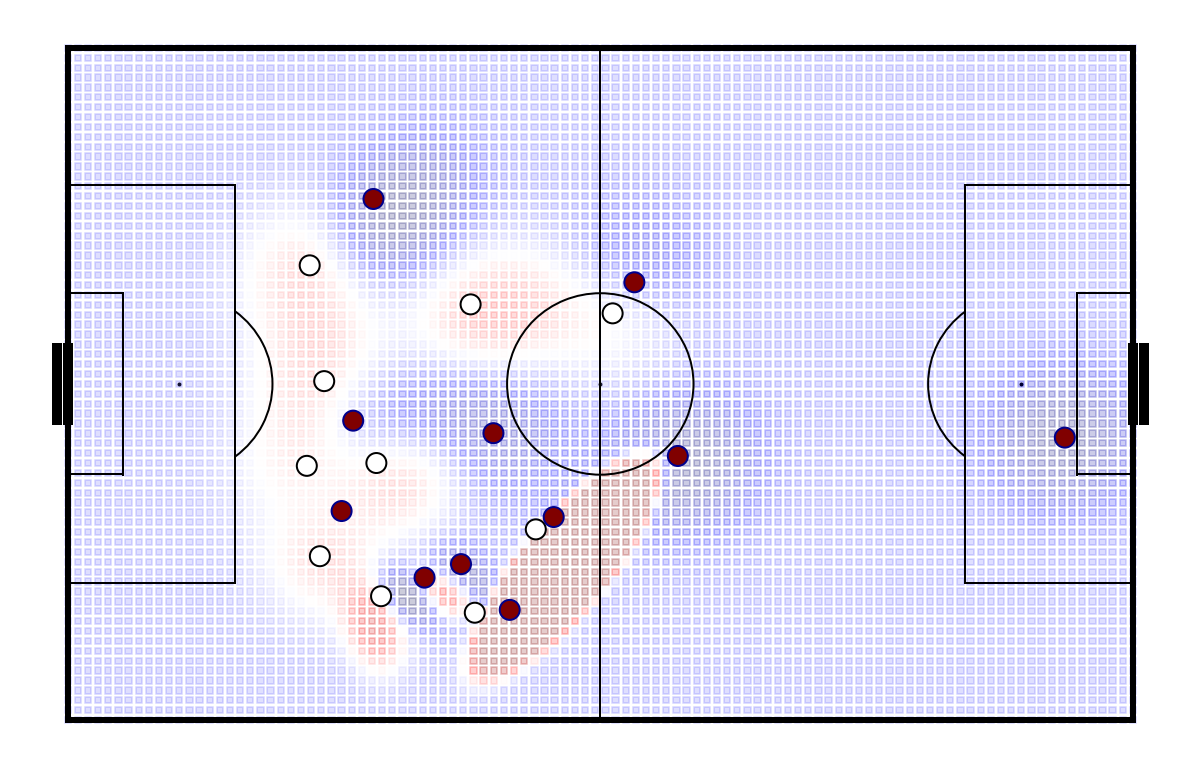

In [10]:
draw.pitch(dpi=144)
frame = df[df.frame == 0]
plt.scatter(grid.x, grid.y, s=10, marker='s', c=grid.control, cmap='seismic', alpha=0.2);
plt.scatter(frame.x, frame.y, s=100, c=frame.bgcolor.values, edgecolors=frame.edgecolor);

In [11]:
locs_home = [df[df.player==player_id][['x', 'y']].astype(float).to_numpy() * np.array([1.05,.68]) for player_id in df[df.team == 'attack'].player.unique()]
locs_away = [df[df.player==player_id][['x', 'y']].astype(float).to_numpy() * np.array([1.05,.68]) for player_id in df[df.team == 'defense'].player.unique()]
locs_ball = [df[df.team.isna()][['x', 'y']].astype(float).to_numpy() * np.array([1.05,.68])]
t = pd.Series([i * 0.04 for i in range(len(locs_home[0]))])

writer = imageio.get_writer('ronaldocalma_javier_version.gif', mode='I')
for frame_no in tqdm(df.frame.unique()):
    yy,xx = np.meshgrid(np.linspace(0,68,69), np.linspace(0,105,106))
    Zh = np.zeros(106*69)
    Za = np.zeros(106*69)
    for k in range(len(locs_home)):
        Zh += influence_function(k,np.c_[xx.flatten(),yy.flatten()],frame_no,'h')
    for k in range(len(locs_away)):
        Za += influence_function(k,np.c_[xx.flatten(),yy.flatten()],frame_no,'a')
    Zh = Zh.reshape((106,69))
    Za = Za.reshape((106,69))

    grid['control'] = 1 - (1 / (1 + np.exp(-Za + Zh))).flatten()

    draw.pitch(dpi=144)
    frame = df[df.frame == frame_no]
    plt.scatter(grid.x, grid.y, s=10, marker='s', c=grid.control, cmap='seismic', alpha=0.2);
    plt.scatter(frame.x, frame.y, s=100, c=frame.bgcolor.values, edgecolors=frame.edgecolor);
    plt.clim(0,1)
    plt.savefig(temp_file_name, bbox_inches='tight')
    plt.clf()
    image = imageio.imread(temp_file_name)
    writer.append_data(image)

  0%|          | 0/289 [00:00<?, ?it/s]/tmp/ipykernel_80874/1018228781.py:18: RuntimeWarning: overflow encountered in exp
  grid['control'] = 1 - (1 / (1 + np.exp(-Za + Zh))).flatten()
100%|██████████| 289/289 [03:22<00:00,  1.43it/s]


<Figure size 1512x979.2 with 0 Axes>